# Загрузка данных

In [2]:
pip install tensorflow_decision_forests optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 2.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement tensorflow~=2.15.0 (from tensorflow-decision-forests) (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow~=2.15.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/bair/miniconda3/envs/my_env/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: tensorflow-macos, tf_keras
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow_decision_forests

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_decision_forests as tfdf
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, fbeta_score
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from keras.layers import GRU, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam

import os
import pickle

AttributeError: module 'inspect' has no attribute 'ArgSpec'

In [ ]:
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/'))

SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-29-a617b8064b82>, line 1)

In [ ]:
# подключаюсь к диску (для колаба)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Загрузка датасета
data_to_train =  pd.read_csv("data_to_train.csv")
data_to_train.head()

,count,publisher_1,publisher_10,publisher_11,publisher_12,publisher_13,publisher_14,publisher_15,publisher_16,publisher_17,...,city_17,city_19,city_201,city_21,city_25,city_3,city_60,city_7,city_8,city_other
0,23,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,6,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
data_to_train = data_to_train.drop(columns=['city_group'])

In [ ]:
data_to_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495001 entries, 0 to 495000
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   count                495001 non-null  int64  
 1   publisher_1          495001 non-null  int64  
 2   publisher_10         495001 non-null  int64  
 3   publisher_11         495001 non-null  int64  
 4   publisher_12         495001 non-null  int64  
 5   publisher_13         495001 non-null  int64  
 6   publisher_14         495001 non-null  int64  
 7   publisher_15         495001 non-null  int64  
 8   publisher_16         495001 non-null  int64  
 9   publisher_17         495001 non-null  int64  
 10  publisher_18         495001 non-null  int64  
 11  publisher_19         495001 non-null  int64  
 12  publisher_2          495001 non-null  int64  
 13  publisher_20         495001 non-null  int64  
 14  publisher_21         495001 non-null  int64  
 15  publisher_3      

In [ ]:
missing_data = data_to_train.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data)

sex           11754
age           11754
sex_binary    11754
dtype: int64


In [ ]:
data_to_train.dropna(inplace=True)  # Удаление всех строк с NaN

In [ ]:
# Определение целевой переменной и признаков
X = data_to_train.drop(columns=['count'])
y = data_to_train['count']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TFDF

In [ ]:
# Объединяем обратно данные для TFDF
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [ ]:
# Преобразование в формат TFDF
train_data_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, task=tfdf.keras.Task.REGRESSION, label='count')
test_data_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task=tfdf.keras.Task.REGRESSION, label='count')

In [ ]:
#Функция для подбора гиперпараметров
def objective(trial):
    # Подбор гиперпараметров
    num_trees = trial.suggest_int("num_trees", 10, 100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_examples = trial.suggest_int("min_examples", 1, 20)

    model = tfdf.keras.GradientBoostedTreesModel(
        num_trees=num_trees,
        max_depth=max_depth,
        min_examples=min_examples,
        task=tfdf.keras.Task.REGRESSION
    )

    # Обучаем модель на тренировочных данных
    model.fit(train_data_tf)

    # Прогнозируем на тестовых данных
    predictions = model.predict(test_data_tf)
    predictions = predictions.flatten()

    # Метрики
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)

    # Возвращаем метрику для оптимизации
    return mse  # Оптимизируем MSE

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)

[I 2024-12-18 06:16:09,969] A new study created in memory with name: no-name-6e3753b4-992a-4a74-90c9-f488271e0516


Use /tmp/tmpc6sx2s62 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:28.668602. Found 386597 examples.
Training model...
Model trained in 0:00:12.606307
Compiling model...
Model compiled.
97/97 [==============================] - 6s 57ms/step


[I 2024-12-18 06:17:02,599] Trial 0 finished with value: 15.32053117555916 and parameters: {'num_trees': 14, 'max_depth': 5, 'min_examples': 14}. Best is trial 0 with value: 15.32053117555916.


Use /tmp/tmplic0u935 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.517594. Found 386597 examples.
Training model...
Model trained in 0:02:17.473929
Compiling model...
Model compiled.
97/97 [==============================] - 7s 73ms/step


[I 2024-12-18 06:19:53,045] Trial 1 finished with value: 7.260354262104474 and parameters: {'num_trees': 54, 'max_depth': 8, 'min_examples': 3}. Best is trial 1 with value: 7.260354262104474.


Use /tmp/tmp4flyluyg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.841771. Found 386597 examples.
Training model...
Model trained in 0:01:22.947802
Compiling model...
Model compiled.
97/97 [==============================] - 6s 60ms/step


[I 2024-12-18 06:21:46,513] Trial 2 finished with value: 8.623414974198841 and parameters: {'num_trees': 74, 'max_depth': 5, 'min_examples': 3}. Best is trial 1 with value: 7.260354262104474.


Use /tmp/tmpndykf_rs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.763368. Found 386597 examples.
Training model...
Model trained in 0:01:26.519073
Compiling model...
Model compiled.
97/97 [==============================] - 8s 79ms/step


[I 2024-12-18 06:23:46,447] Trial 3 finished with value: 8.460012488279764 and parameters: {'num_trees': 76, 'max_depth': 5, 'min_examples': 15}. Best is trial 1 with value: 7.260354262104474.


Use /tmp/tmp1uzxu6oz as temporary training directory
Reading training dataset...


Training dataset read in 0:00:23.745693. Found 386597 examples.
Training model...
Model trained in 0:03:52.940570
Compiling model...
Model compiled.


97/97 [==============================] - 7s 71ms/step


[I 2024-12-18 06:28:14,699] Trial 4 finished with value: 6.884725897284013 and parameters: {'num_trees': 62, 'max_depth': 10, 'min_examples': 5}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpb5wr3feo as temporary training directory
Reading training dataset...


Training dataset read in 0:00:27.548532. Found 386597 examples.
Training model...
Model trained in 0:00:28.714819
Compiling model...
Model compiled.


97/97 [==============================] - 8s 79ms/step


[I 2024-12-18 06:29:45,297] Trial 5 finished with value: 12.392905834919969 and parameters: {'num_trees': 72, 'max_depth': 3, 'min_examples': 14}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpsdfhlyh3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.206025. Found 386597 examples.
Training model...
Model trained in 0:00:45.972832
Compiling model...
Model compiled.
97/97 [==============================] - 8s 78ms/step


[I 2024-12-18 06:31:15,830] Trial 6 finished with value: 10.265702026215438 and parameters: {'num_trees': 63, 'max_depth': 4, 'min_examples': 4}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpt2znwb5d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:22.232912. Found 386597 examples.
Training model...
Model trained in 0:02:50.038916
Compiling model...
Model compiled.
97/97 [==============================] - 6s 60ms/step


[I 2024-12-18 06:34:34,758] Trial 7 finished with value: 7.107940280729675 and parameters: {'num_trees': 65, 'max_depth': 8, 'min_examples': 16}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpsgu629nc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.794653. Found 386597 examples.
Training model...
Model trained in 0:03:37.196508
Compiling model...
Model compiled.
97/97 [==============================] - 7s 66ms/step


[I 2024-12-18 06:38:45,125] Trial 8 finished with value: 6.93686680374387 and parameters: {'num_trees': 56, 'max_depth': 10, 'min_examples': 4}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpin60a2nn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:26.378912. Found 386597 examples.
Training model...
Model trained in 0:02:30.602606
Compiling model...
Model compiled.
97/97 [==============================] - 8s 80ms/step


[I 2024-12-18 06:41:50,965] Trial 9 finished with value: 7.502981687168658 and parameters: {'num_trees': 98, 'max_depth': 6, 'min_examples': 1}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmp6h3uvkri as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.347516. Found 386597 examples.
Training model...
Model trained in 0:01:57.263610
Compiling model...
Model compiled.
97/97 [==============================] - 6s 65ms/step


[I 2024-12-18 06:44:23,639] Trial 10 finished with value: 7.4526486937691425 and parameters: {'num_trees': 32, 'max_depth': 10, 'min_examples': 9}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpetkiq52r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.580053. Found 386597 examples.
Training model...
Model trained in 0:03:06.742590
Compiling model...
Model compiled.
97/97 [==============================] - 8s 82ms/step


[I 2024-12-18 06:48:02,830] Trial 11 finished with value: 7.033811995794643 and parameters: {'num_trees': 49, 'max_depth': 10, 'min_examples': 8}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpmxpkuc54 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.412295. Found 386597 examples.
Training model...
Model trained in 0:02:05.392572
Compiling model...
Model compiled.
97/97 [==============================] - 8s 78ms/step


[I 2024-12-18 06:50:40,118] Trial 12 finished with value: 7.3447103403512255 and parameters: {'num_trees': 40, 'max_depth': 9, 'min_examples': 20}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpqnmwlitb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.491217. Found 386597 examples.
Training model...
Model trained in 0:03:47.852206
Compiling model...
Model compiled.
97/97 [==============================] - 6s 64ms/step


[I 2024-12-18 06:54:59,005] Trial 13 finished with value: 6.916617065841808 and parameters: {'num_trees': 90, 'max_depth': 8, 'min_examples': 6}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpzqkm3dnc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.723668. Found 386597 examples.
Training model...
Model trained in 0:03:48.760211
Compiling model...
Model compiled.
97/97 [==============================] - 8s 78ms/step


[I 2024-12-18 06:59:21,082] Trial 14 finished with value: 6.917709869199072 and parameters: {'num_trees': 92, 'max_depth': 8, 'min_examples': 7}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpklv4f3ru as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.427579. Found 386597 examples.
Training model...
Model trained in 0:02:42.775662
Compiling model...
Model compiled.
97/97 [==============================] - 6s 62ms/step


[I 2024-12-18 07:02:34,210] Trial 15 finished with value: 7.20734622450781 and parameters: {'num_trees': 85, 'max_depth': 7, 'min_examples': 6}. Best is trial 4 with value: 6.884725897284013.


Use /tmp/tmpm28x7zwy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.681512. Found 386597 examples.
Training model...
Model trained in 0:04:27.402080
Compiling model...
Model compiled.
97/97 [==============================] - 7s 70ms/step


[I 2024-12-18 07:07:37,364] Trial 16 finished with value: 6.787776002876984 and parameters: {'num_trees': 85, 'max_depth': 9, 'min_examples': 11}. Best is trial 16 with value: 6.787776002876984.


Use /tmp/tmpu2xen46v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:26.806321. Found 386597 examples.
Training model...
Model trained in 0:04:10.244950
Compiling model...
Model compiled.
97/97 [==============================] - 6s 64ms/step


[I 2024-12-18 07:12:22,075] Trial 17 finished with value: 6.812968459209704 and parameters: {'num_trees': 81, 'max_depth': 9, 'min_examples': 11}. Best is trial 16 with value: 6.787776002876984.


Use /tmp/tmpznamarq0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:27.337961. Found 386597 examples.
Training model...
Model trained in 0:04:08.881346
Compiling model...
Model compiled.
97/97 [==============================] - 6s 62ms/step


[I 2024-12-18 07:17:05,202] Trial 18 finished with value: 6.825146717671274 and parameters: {'num_trees': 79, 'max_depth': 9, 'min_examples': 11}. Best is trial 16 with value: 6.787776002876984.


Use /tmp/tmp5uatvqxb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:27.365311. Found 386597 examples.
Training model...
Model trained in 0:03:10.269723
Compiling model...
Model compiled.
97/97 [==============================] - 8s 80ms/step


[I 2024-12-18 07:20:53,870] Trial 19 finished with value: 7.096661159493409 and parameters: {'num_trees': 99, 'max_depth': 7, 'min_examples': 11}. Best is trial 16 with value: 6.787776002876984.


Use /tmp/tmp_sevt_9u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.346019. Found 386597 examples.
Training model...
Model trained in 0:04:27.400868
Compiling model...
Model compiled.
97/97 [==============================] - 8s 84ms/step


[I 2024-12-18 07:25:53,714] Trial 20 finished with value: 6.7811764749963075 and parameters: {'num_trees': 85, 'max_depth': 9, 'min_examples': 12}. Best is trial 20 with value: 6.7811764749963075.


Use /tmp/tmpi20s56n8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.655977. Found 386597 examples.
Training model...
Model trained in 0:04:50.892216
Compiling model...
Model compiled.
97/97 [==============================] - 10s 106ms/step


[I 2024-12-18 07:31:29,700] Trial 21 finished with value: 6.785745825030518 and parameters: {'num_trees': 84, 'max_depth': 9, 'min_examples': 12}. Best is trial 20 with value: 6.7811764749963075.


Use /tmp/tmp7ycwkbre as temporary training directory
Reading training dataset...
Training dataset read in 0:00:30.133307. Found 386597 examples.
Training model...
Model trained in 0:04:43.744902
Compiling model...
Model compiled.
97/97 [==============================] - 6s 62ms/step


[I 2024-12-18 07:36:50,476] Trial 22 finished with value: 6.764570329613457 and parameters: {'num_trees': 90, 'max_depth': 9, 'min_examples': 13}. Best is trial 22 with value: 6.764570329613457.


Use /tmp/tmphywc7s63 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:25.059508. Found 386597 examples.
Training model...
Model trained in 0:03:00.033115
Compiling model...
Model compiled.
97/97 [==============================] - 6s 62ms/step


[I 2024-12-18 07:41:19,517] Trial 23 finished with value: 7.1494381014727715 and parameters: {'num_trees': 92, 'max_depth': 7, 'min_examples': 17}. Best is trial 22 with value: 6.764570329613457.


Use /tmp/tmpbmaldy6k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.875410. Found 386597 examples.
Training model...
Model trained in 0:03:41.536360
Compiling model...
Model compiled.
97/97 [==============================] - 7s 71ms/step


[I 2024-12-18 07:45:33,833] Trial 24 finished with value: 6.893493487070169 and parameters: {'num_trees': 69, 'max_depth': 9, 'min_examples': 13}. Best is trial 22 with value: 6.764570329613457.


Use /tmp/tmpy1bodyzb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.105467. Found 386597 examples.
Training model...
Model trained in 0:04:07.378381
Compiling model...
Model compiled.
97/97 [==============================] - 6s 62ms/step


[I 2024-12-18 07:50:12,217] Trial 25 finished with value: 6.8760453506974715 and parameters: {'num_trees': 100, 'max_depth': 8, 'min_examples': 18}. Best is trial 22 with value: 6.764570329613457.


Use /tmp/tmpv5_16287 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.867483. Found 386597 examples.
Training model...
Model trained in 0:04:34.604077
Compiling model...
Model compiled.
97/97 [==============================] - 8s 81ms/step


[I 2024-12-18 07:55:43,082] Trial 26 finished with value: 6.774940730622532 and parameters: {'num_trees': 88, 'max_depth': 9, 'min_examples': 13}. Best is trial 22 with value: 6.764570329613457.


Use /tmp/tmplrbndofo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.280639. Found 386597 examples.
Training model...
Model trained in 0:02:20.560706
Compiling model...
Model compiled.
97/97 [==============================] - 8s 82ms/step


[I 2024-12-18 07:58:35,705] Trial 27 finished with value: 7.534779664681103 and parameters: {'num_trees': 91, 'max_depth': 6, 'min_examples': 9}. Best is trial 22 with value: 6.764570329613457.


Use /tmp/tmpoetnrsn_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.066082. Found 386597 examples.
Training model...
Model trained in 0:00:40.941720
Compiling model...
Model compiled.
97/97 [==============================] - 6s 63ms/step


[I 2024-12-18 08:00:08,815] Trial 28 finished with value: 9.914085859558 and parameters: {'num_trees': 22, 'max_depth': 7, 'min_examples': 13}. Best is trial 22 with value: 6.764570329613457.


Use /tmp/tmp9r31qy4h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.459198. Found 386597 examples.
Training model...
Model trained in 0:01:06.941661
Compiling model...
Model compiled.
97/97 [==============================] - 7s 67ms/step


[I 2024-12-18 08:02:38,308] Trial 29 finished with value: 9.03876080547652 and parameters: {'num_trees': 18, 'max_depth': 10, 'min_examples': 15}. Best is trial 22 with value: 6.764570329613457.


In [ ]:
best_params = study.best_params

In [ ]:
tfdf_model = tfdf.keras.GradientBoostedTreesModel(
    num_trees=best_params["num_trees"],
    max_depth=best_params["max_depth"],
    min_examples=best_params["min_examples"],
    task=tfdf.keras.Task.REGRESSION
)

Use /tmp/tmpj6qkki9s as temporary training directory


In [ ]:
# Обучаем финальную модель
tfdf_model.fit(train_data_tf)

Reading training dataset...
Training dataset read in 0:00:25.676723. Found 386597 examples.
Training model...
Model trained in 0:05:26.898211
Compiling model...
Model compiled.


In [ ]:
# Прогнозируем на тестовых данных
final_predictions = tfdf_model.predict(test_data_tf)
final_predictions = final_predictions.flatten()


97/97 [==============================] - 14s 143ms/step


In [ ]:
# Оценка метрик
mse_ftdf = mean_squared_error(y_test, final_predictions)
mae_tfdf = mean_absolute_error(y_test, final_predictions)
r2_tfdf = r2_score(y_test, final_predictions)
print(f"Final MSE: {mse_ftdf}")
print(f"Final MAE: {mae_tfdf}")
print(f'R2_score: {r2_tfdf* 100 :.2f}%')

Final MSE: 6.764570329613457
Final MAE: 1.7760920675640826
R2_score: 87.64%


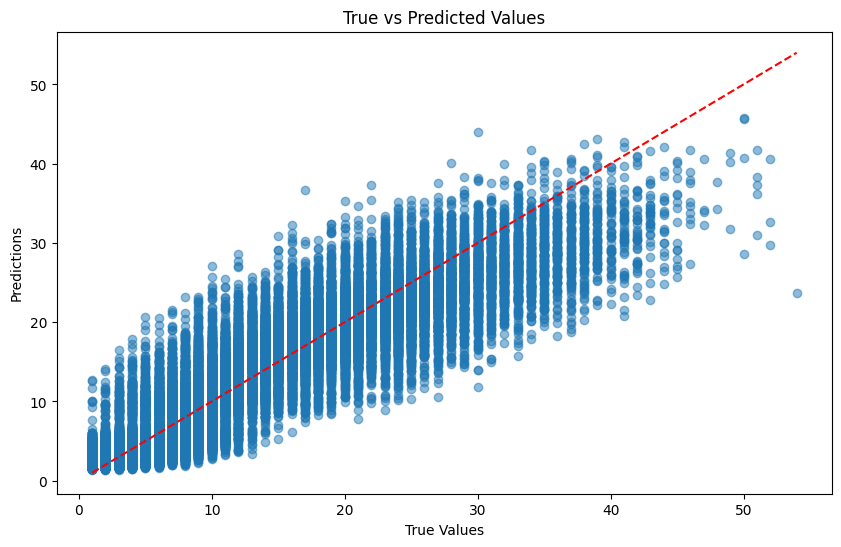

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # линия идеальных предсказаний
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [ ]:
tfdf_model_path = '/content/drive/MyDrive/Colab Notebooks/tfdf_model.pkl'
os.makedirs(tfdf_model_path, exist_ok=True)
tfdf_model.save(tfdf_model_path)

# Сериализуем модель в формате .pkl
model_data = {
    'model_path': tfdf_model_path,
}

In [ ]:
# Сохранение модели с помощью pickle
with open('/content/drive/MyDrive/Colab Notebooks/tfdf_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)

# LSTM

In [ ]:
#
features = data_to_train.drop(columns=['count'])
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Целевая переменная
target = data_to_train['count'].values

In [ ]:
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:(i + time_step)])
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

# Определяем количество временных шагов
time_step = 10

# Создаем обучающий набор
X, y = create_dataset(scaled_features, target, time_step)

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Убедимся, что данные имеют правильную форму
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (386589, 10, 64), Test shape: (96648, 10, 64)


In [ ]:
# Создание модели
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
#model.add(Dense(64))
lstm_model.add(Dense(1))  # Выход для предсказания `count`

# Компиляция модели
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Ранняя остановка
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Обучаем модель
lstm_model.fit(X_train, y_train,
               epochs=100,
               batch_size=32,
               validation_split=0.2,
               callbacks=[early_stopping])  # Используем раннюю остановку

Epoch 1/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 151s 15ms/step - loss: 22.7324 - val_loss: 11.7501
Epoch 2/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 205s 15ms/step - loss: 12.3035 - val_loss: 10.9715
Epoch 3/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 199s 15ms/step - loss: 11.6648 - val_loss: 10.6961
Epoch 4/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 205s 15ms/step - loss: 11.1889 - val_loss: 10.4528
Epoch 5/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 200s 15ms/step - loss: 10.9852 - val_loss: 10.3633
Epoch 6/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 202s 15ms/step - loss: 10.8744 - val_loss: 10.4254
Epoch 7/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 147s 15ms/step - loss: 10.6365 - val_loss: 10.3826
Epoch 8/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 150s 16ms/step - loss: 10.6409 - val_loss: 10.4598
Epoch 9/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 201s 15ms/step - loss: 10.6396 - val_loss: 10.3772
Epoch 10/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 149s 15ms/step - loss: 10.3848 - val_loss: 10.1495
Epoch 11/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 153s 16ms/step 

In [ ]:
# Прогнозирование на тестовых данных
y_pred = lstm_model.predict(X_test)


3021/3021 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step


In [ ]:
# Оценка метрик
mse_lstm = mean_squared_error(y_test, y_pred)
mae_lstm = mean_absolute_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)
print(f"Final MSE: {mse_lstm}")
print(f"Final MAE: {mae_lstm}")
print(f'R2_score: {r2_lstm* 100 :.2f}%')

Final MSE: 10.244029818187997
Final MAE: 2.062082268105873
R2_score: 81.42%


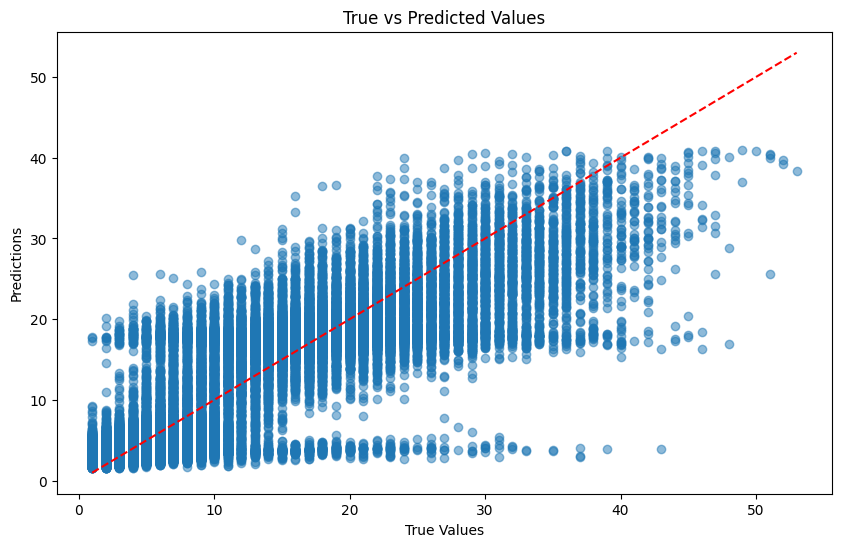

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # линия идеальных предсказаний
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [ ]:
# Сохраняем модель в pkl файл
model_filename = '/content/drive/MyDrive/Colab Notebooks/lstm_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(lstm_model, file)

print("Модель успешно сохранена в", model_filename)

Модель успешно сохранена в /content/drive/MyDrive/Colab Notebooks/lstm_model.pkl


# GRU



In [ ]:
# Определяем целевую переменную и признаки
X = data_to_train.drop(columns=['count'])  # Признаки
y = data_to_train['count']                 # Целевая переменная


In [ ]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Преобразование данных для GRU
# Для примера, мы будем использовать один временной шаг, добавляя дополнительное измерение
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
# Создаем модель RNN с использованием GRU
gru_model = Sequential()

In [ ]:
# Добавляем GRU слой с L2 регуляризацией
gru_model.add(GRU(64,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=False,
               kernel_regularizer=l2(0.01)))  # Регуляризация L2 на 'kernel'
gru_model.add(Dropout(0.2))  # Регуляризация с помощью Dropout

# Полносвязный слой с L2 регуляризацией
gru_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Регуляризация L2 на 'kernel'
gru_model.add(Dropout(0.2))  # Регуляризация с помощью Dropout

# Выходной слой
gru_model.add(Dense(1, activation='linear'))  # Предсказание непрерывного значения

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Компилируем модель с оптимизатором Adam
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Оптимизатор Adam


In [ ]:
# Ранняя остановка
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Обучаем модель
gru_model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          validation_split=0.2,
          callbacks=[early_stopping])  # Используем раннюю остановку

Epoch 1/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 18.9805 - val_loss: 10.6090
Epoch 2/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 11.9664 - val_loss: 10.2395
Epoch 3/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 11.3858 - val_loss: 9.9885
Epoch 4/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 11.2387 - val_loss: 10.2233
Epoch 5/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 11.2571 - val_loss: 9.8256
Epoch 6/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 11.1182 - val_loss: 9.9277
Epoch 7/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 11.0974 - val_loss: 9.9184
Epoch 8/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 11.0806 - val_loss: 9.8778
Epoch 9/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 11.0386 - val_loss: 9.8969
Epoch 10/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 11.0935 - val_loss: 9.7660
Epoch 11/100
9665/9665 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 11.0528 - val_loss: 9

In [ ]:
# Прогнозирование на тестовых данных
y_pred = gru_model.predict(X_test)


3021/3021 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [ ]:
# Оценка метрик
mse_gru = mean_squared_error(y_test, y_pred)
mae_gru = mean_absolute_error(y_test, y_pred)
r2_gru = r2_score(y_test, y_pred)
print(f"Final MSE: {mse_lstm}")
print(f"Final MAE: {mae_lstm}")
print(f'R2_score: {r2_lstm* 100 :.2f}%')

Final MSE: 9.0867146195692
Final MAE: 2.0326943561590465
R2_score: 83.39%


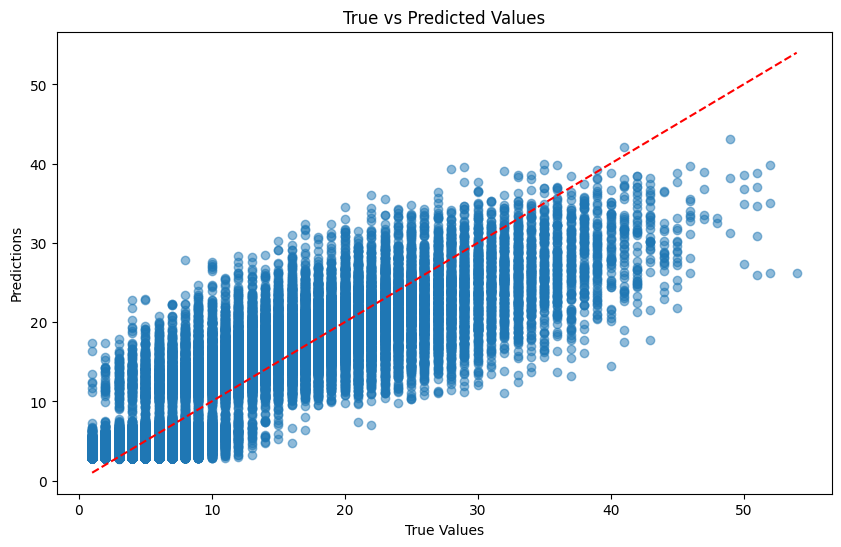

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # линия идеальных предсказаний
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [ ]:
# Сохраняем модель в pkl файл
model_filename = '/content/drive/MyDrive/Colab Notebooks/gru_model.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(gru_model, file)

print("Модель успешно сохранена в", model_filename)

Модель успешно сохранена в /content/drive/MyDrive/Colab Notebooks/gru_model.pkl


# Сравнение моделей

In [6]:
# Соберем основные метрики по моделям в одну таблицу
regression_df = pd.DataFrame(
    data = [
        [f'{mse_ftdf:.4f}', f'{mse_lstm:.4f}', f'{mse_gru:.4f}'],
        [f'{mae_tfdf:.4f}', f'{mae_lstm:.4f}', f'{mae_gru:.4f}'],
        [f'{r2_tfdf*100:.1f}%', f'{r2_lstm*100:.1f}%', f'{r2_gru*100:.1f}%']
    ],
    columns= ['TFDF', 'LSTM', 'GRU'],
    index = ['MSE', 'MAE', 'R2-score']
)
display(regression_df)

,TFDF,LSTM,GRU
MSE,6.7646,10.2440,9.0867
MAE,1.7761,2.0621,2.0327
R2-score,87.6%,81.4%,83.4%


> DL модели в целом показали хорошие результаты (R² > 80%), однако TFDF значительно превосходит LSTM и GRU.
> TFDF ближе по качеству к классическим моделям ML (таким как XGBoost), в то время как LSTM и GRU имеют более высокие ошибки предсказаний и требуют дальнейшей оптимизации.